In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve

from filters import discrete_bayes_predict, discrete_bayes_update

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dog position tracking

A dog is walking on a rectangular hallway with 10 positions (0 to 9).<br>
Some of these positions represent doors, some are halls.<br>
The dog wears a sensor that indicates if it is in front of a door or a hall.<br>

Let's calculate the prior, which is the probability of the dog position before incorporating any measurements:


In [3]:
# initial belief of dog position (we just assume that the dog is
# as likely to be in any position)
belief = np.array([1/10]*10)
belief

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

This is the map of the hallway:

In [4]:
# there is two doors in the first positions, and then another door farther away
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
hallway

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

The first sensor reading indicates <b>door</b>.

In [5]:
# we dont really know which door, the dog is as likely to be in front
# of any of the three. So, assuming the sensor is perfect, our new belief is:

perfect_belief = hallway * (1/3)
perfect_belief

array([0.33333333, 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.33333333, 0.        ])

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]
1.0


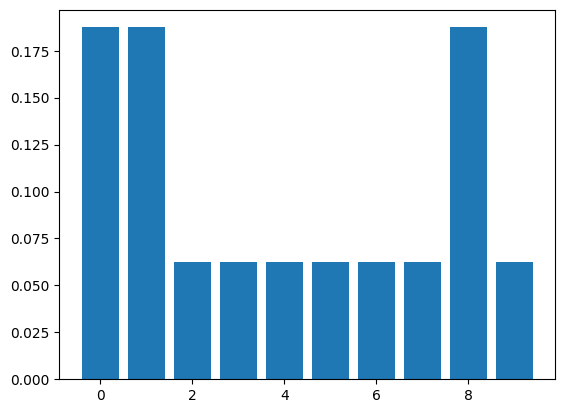

In [6]:
# but no sensor is perfect (noise)
# I cannot assign the full 1/3 to the sensor, as it may contain error
# I also need to assign a small probability to the other positions
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale
    # now I normalize the results, so it will be expressed as a
    # probability distribution (sums up to 1)
    belief = belief/sum(belief)
    return belief

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
correct_scale = 3. # assume sensor is 3 times more likely right than wrong
belief = update_belief(hallway, belief, z=reading, correct_scale=correct_scale)
plt.bar(np.arange(len(belief)), belief)
print(belief)
print(sum(belief))

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]
1.0


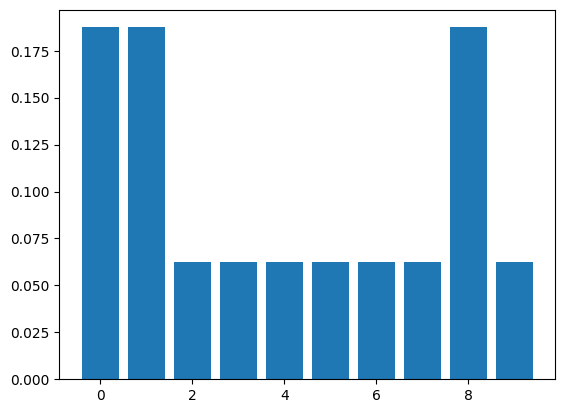

In [7]:
# refactoring the code
def scaled_update(hall, belief, z, z_prob): 
    # we calcuate the scale based on the probability of the sensor
    # being correct (prob_correct / prob_incorrect)
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    # vectorized way of applying the scale
    likelihood[hall==z] *= scale # here we are computing the likelihood
    likelihood = likelihood/sum(likelihood)
    return likelihood

prior = np.array([0.1] * 10) # probability distribution before including measurements

# probability distribution after incorporating measurement information
posterior = scaled_update(hallway, belief, z=1, z_prob=.75)

plt.bar(np.arange(len(posterior)), posterior)
print(posterior)
print(sum(posterior))

The above function is the following:

posterior = (likelihood * prior) / normalization

In [8]:
def normalize(value):
    return value/sum(value)

def update(likelihood, prior):
    return normalize(likelihood * prior)

In [9]:
# the likelihood computation is specific for the problem
# here is a scaling simulating the uncertainty of the measurement
# the noise of the sensor measuring the dog position

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

Incorporating movement: now the dog has moved to the right.<br>
How does that affect the prior?

<BarContainer object of 10 artists>

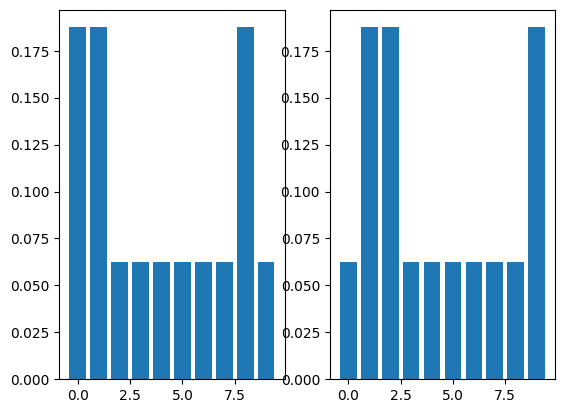

In [10]:
# in a perfect sensor, we move all the predictions to the right
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result

plt.subplot(121)
plt.bar(x=np.arange(len(belief)), height=belief)

belief = perfect_predict(belief, 1)
plt.subplot(122)
plt.bar(x=np.arange(len(belief)), height=belief)

Now we add uncertainty to the prediction.<br>
Here, we simplify the problem for visualization. If the sensor is 80% likely to be correct, 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left.<br>
After the dog moves, we have the following:

<BarContainer object of 10 artists>

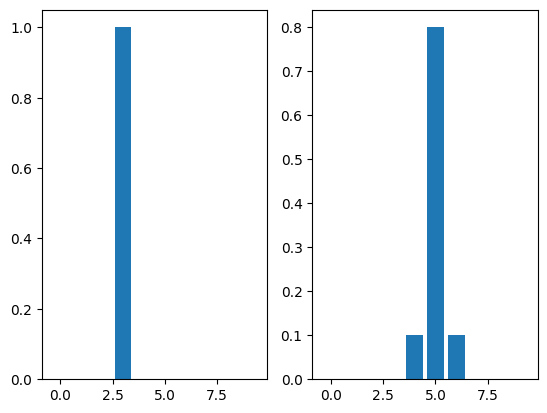

In [11]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
plt.subplot(121)
plt.bar(x=np.arange(len(belief)), height=belief)

prior = predict_move(belief, 2, .1, .8, .1)
plt.subplot(122)
plt.bar(x=np.arange(len(belief)), height=prior)

<BarContainer object of 10 artists>

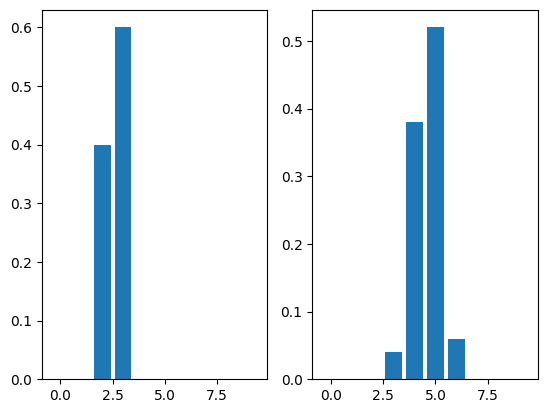

In [12]:
# if the beliefs themselves are not 100% certain:

belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
plt.subplot(121)
plt.bar(x=np.arange(len(belief)), height=belief)

prior = predict_move(belief, 2, .1, .8, .1)
plt.subplot(122)
plt.bar(x=np.arange(len(belief)), height=prior)


Observe that the probabilities are now overall lower and spread across the plot.<br>
This means that <b>if the sensor is noisy, we lose information</b> at every step.

We just performed a <b>Convolution</b>. Convolution modifies one function with another function. In our case we are modifying a probability distribution with the error function of the sensor. 

In [13]:
# here is a slow implementation of the convolution
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

<BarContainer object of 10 artists>

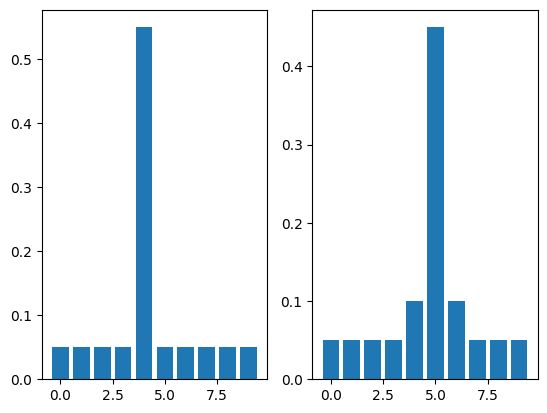

In [14]:
pdf = belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
offset = 1 # must be integer
kernel=[.1, .8, .1]

# here is a faster implementation with scipy
prior = convolve(np.roll(pdf, offset), kernel, mode='wrap')

plt.subplot(121)
plt.bar(x=np.arange(len(belief)), height=belief)
plt.subplot(122)
plt.bar(x=np.arange(len(belief)), height=prior)

<b>Starting the predict / update cycles</b>

Initial belief (prior) and update with the dog position.

Text(0.5, 1.0, 'posterior')

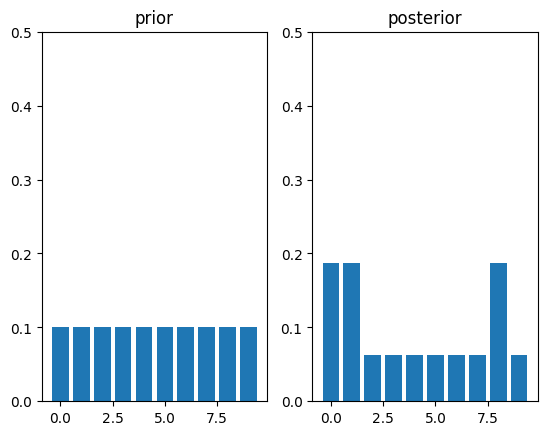

In [27]:
# now implementing it all

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)

# z: the sensor indicates the dog is at the door
# z_prob: how much we believe the sensor is correct
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)

plt.subplot(121)
plt.bar(x=np.arange(len(prior)), height=prior)
plt.ylim(0, .5) 
plt.title('prior')
plt.subplot(122)
plt.bar(x=np.arange(len(posterior)), height=posterior)
plt.ylim(0, .5) 
plt.title('posterior')

With the calculated posterior, make another prediction considering the belief on the sensor righteousness (kernel).

Text(0.5, 1.0, 'posterior')

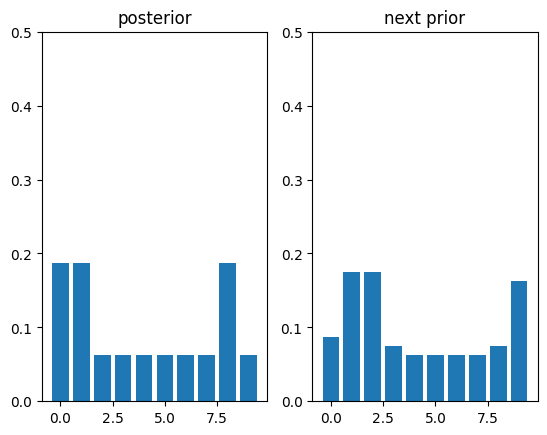

In [31]:
# now the dog moves to the right
# we believe the sensor is 80% at the right value, undershoots by 10% and overshoots by 10%
kernel = (.1, .8, .1)
prior = discrete_bayes_predict(posterior, 1, kernel)

plt.subplot(122)
plt.bar(x=np.arange(len(prior)), height=prior)
plt.ylim(0, .5)
plt.title('next prior')
plt.subplot(121)
plt.bar(x=np.arange(len(posterior)), height=posterior)
plt.ylim(0, .5)
plt.title('posterior')

Get another sensor measurement (likelihood) and update the state using the prediction from last step (prior).

Text(0.5, 1.0, 'posterior')

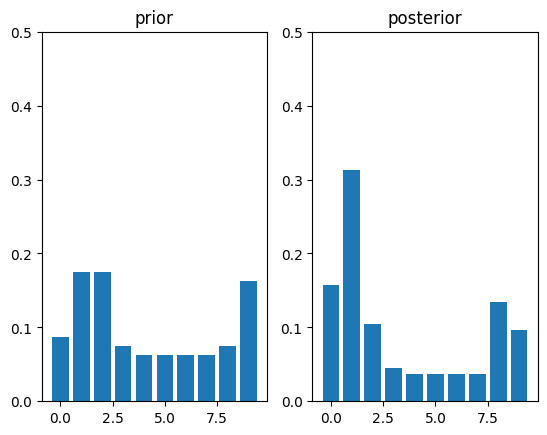

In [34]:
# update with measurement information

# now the next measurement, after a shift to the right, the sensor measures another door
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)

plt.subplot(121)
plt.bar(x=np.arange(len(prior)), height=prior)
plt.ylim(0, .5) 
plt.title('prior')
plt.subplot(122)
plt.bar(x=np.arange(len(posterior)), height=posterior)
plt.ylim(0, .5) 
plt.title('posterior')

Make a prediction for the next prior using the posterior and the belief on the sensor righteousness (kernel).

Text(0.5, 1.0, 'posterior')

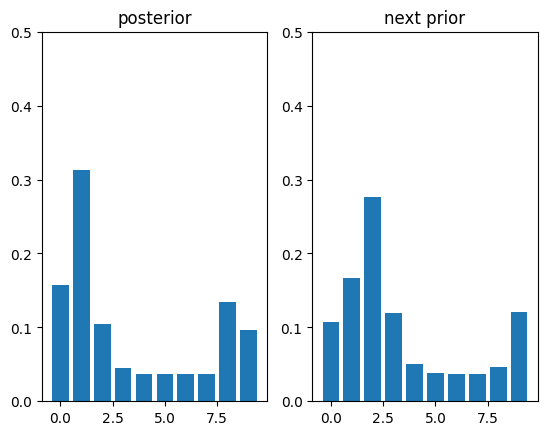

In [35]:
prior = discrete_bayes_predict(posterior, 1, kernel)

plt.subplot(122)
plt.bar(x=np.arange(len(prior)), height=prior)
plt.ylim(0, .5)
plt.title('next prior')
plt.subplot(121)
plt.bar(x=np.arange(len(posterior)), height=posterior)
plt.ylim(0, .5)
plt.title('posterior')

Get another measurement (likelihood) and update the state using the previous prediction (prior).

Text(0.5, 1.0, 'posterior')

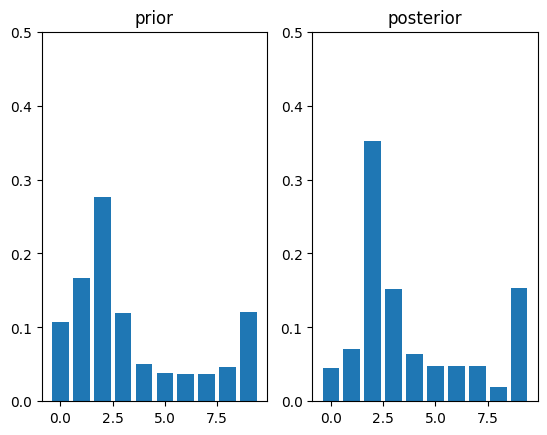

In [36]:
# update with measurement information

# now the next measurement, after a shift to the right, the sensor measures a hall
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)

plt.subplot(121)
plt.bar(x=np.arange(len(prior)), height=prior)
plt.ylim(0, .5) 
plt.title('prior')
plt.subplot(122)
plt.bar(x=np.arange(len(posterior)), height=posterior)
plt.ylim(0, .5) 
plt.title('posterior')

<b>Note</b>:

This is assuming the process model does not change. What happens then the process model changes (for example, the dog stops walking and starts running)?<br>
So far we will just keep the assumption that the sensor can detect those changes.

### The Discrete Bayes AND Kalman filter algorithm:

<b>Initialization</b>

1. Initialize our belief in the state

<b>Predict</b>

1. Based on the system behavior, predict state for the next time step
2. Adjust belief to account for the uncertainty in prediction

<b>Update</b>

1. Get a measurement and associated belief about its accuracy
2. Compute how likely it is the measurement matches each state
3. Update state belief with this likelihood